In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# We will start by importing our necessary pacakges:
import hazel
import numpy as np 
import matplotlib.pyplot as plt 
import h5py

In [2]:
import matplotlib
font = {'size'   : 18}

matplotlib.rc('font', **font)

# Simple inversion demonstration


#### In this notebook we will demonstrate the process of inverting a single polarized spectrum with the goal of obtaining the parameters of the slab: magnetic field vector (Bx, By, Bz), optical depth, los and thermal velocity, and damping. We also have an option of fitting the ad-hoc beta parameter, that we will not use. We will also always assume filling factor is 1, i.e. we are not mixing multiple models for a single spectrum. 

#### Let's start by generating an example spectrum, and adding some noise to it. We will do it for different lines-of-sight and also for different strenghts of the magnetic field. That is, we will compare Zeeman and Hanle regime. 

#### Let's go! 

## We will start with a slab at the disk center, with strong magnetic field.

In [ ]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 201], 'topology': 'ch1',
    'LOS': [0.0,0.0,0.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 5.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod.setup()

# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff. 
# Can you tell me which of the B components is los one, and which ones lie in the plane of the sky?
# Parameters: (Bx,By,Bz,tau,v,deltav,beta,a)

params_original = [500.0,700.0,1000.0, 1.0 ,0.0, 5.0, 1.0, 0.01]

mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = np.copy(mod.spectrum['spec1'].wavelength_axis)
n_wvl = len(ll)

plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")
plt.tight_layout()

### Take a look at the values of polarization - how do they compare, with other lines we know of?

### Now, let's add some noise, and see how the data looks then. After that we will set-up the inversion!

In [ ]:
noise_lvl = 2E-4

noise = np.random.normal(0,noise_lvl,4*n_wvl).reshape(4,n_wvl)
stokes = np.copy(mod.spectrum['spec1'].stokes) + noise

In [ ]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

#### Now our next step is to store this data (spectra, noise, weigths, line-of-sight) in a way where a new hazel model, intended for inversion can read it, and hopefully give us some meaningful results. It would be ideal if we got back our original magnetic field that we put in! 

In [ ]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

In [ ]:
# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

In [ ]:
# And finally, the 'observed' Stokes parameters:

f = open('10830_test_stokes.1d', 'wb')

f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

### Take a look at the files you just made! 

. 

.

.

.

.

### Ok, the next step is to set-up an inversion. 

### To do that, you want to play with our config (i.e. 'ini') file. Let's do that in a separate editor.

.

.

.

.

.

### And after that you are ready for an inversion! 

In [ ]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
del(mod)
iterator = hazel.Iterator(use_mpi=False)

mod = hazel.Model('conf_zeeman.ini', working_mode='inversion', verbose=3, rank=iterator.get_rank(), randomization=1)

iterator.use_model(model=mod)
iterator.run_all_pixels()

## Discuss the output a little bit. There is a lot to learn about the progress of our inversion just by looking at it!


### Now, let's analyze the results: 

In [ ]:
# First, let's see if the spectrum fits at all! 
result = h5py.File('output_onepixel.h5','r')
result.keys()

In [ ]:
result['spec1'].keys()

In [ ]:
result['ch1'].keys()

In [ ]:
fit = np.copy(result['spec1']['stokes'])
fit.shape

In [ ]:
# Shape is; # of pixels, # of randomizations, # Stokes components (4), # wavelengths 

In [ ]:
fit = fit.reshape(1,4,n_wvl)
fit.shape

### Let's compare the fit with the 'observed' spectrum to see if our inversion did what it was supposed to do:

In [ ]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[0,1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[0,2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[0,3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

## Let's see if we managed to recover the physical parameters:

In [ ]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0], "Uncertainty = ", result['ch1']['Bx_err'][0,0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1], "Uncertainty = ", result['ch1']['By_err'][0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2], "Uncertainty = ", result['ch1']['Bz_err'][0,0])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3], "Uncertainty = ", result['ch1']['tau_err'][0,0])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4], "Uncertainty = ", result['ch1']['v_err'][0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5], "Uncertainty = ", result['ch1']['deltav_err'][0,0])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7], "Uncertainty = ", result['ch1']['a_err'][0,0])
#result.close()

In [ ]:
result.close()
%rm output_onepixel.h5

## 1) The parameters are very close to the original ones. Go back now and increase the amount of 'noise' in our data. What happens to the inferred parameters?
.
.
.

## 2) If you were (un)lucky, you might have gotten a 'flipped' solution for Bx,By. Why is this so? Is this the error of the code or something else? If you did not get the flipped solution, go change the starting parameters in your chromosphere.1d file to get it.

.
.
.
## 3) For those of you who want an additional (homework) problem. Go back and set the code to fit only Stokes I, using thermodynamic parameters in first cycle, and only Q,U and V in the second cycle. Can you recover input parameters? Why?


.

.

.


## Now something completely different: A slab at the limb, with very weak magnetic field!

### What should the LOS be? What are the boundary conditions? 

### What physics do you expect? How strong polarization do you expect?

In [ ]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 201], 'topology': 'ch1',
    'LOS': [90.0,0.0,0.0], 'Boundary condition': [0.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod.setup()
# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff
params_original = [3.0,-4.0,7.0,0.5,0.0,8.0,1.0,0.2]
mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = np.copy(mod.spectrum['spec1'].wavelength_axis)
n_wvl = len(ll)
print (n_wvl)

plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.ylabel("Stokes Q / Imax")
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.ylabel("Stokes U / Imax")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.ylabel("Stokes V / Imax")
plt.xlabel("Wavelength")
plt.tight_layout()

#### Note that in this case, Stokes V is very weak. We will set a very low noise as well, to be able to fit it, but generally expect noisy spectra in this case! 

In [ ]:
# Generate random noise of a given amplitude.
noise_lvl = 2E-4

random_noise = np.random.normal(0,noise_lvl,4*n_wvl)
random_noise = random_noise.reshape(4,n_wvl)
stokes = np.copy(mod.spectrum['spec1'].stokes) + random_noise

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.tight_layout()

In [ ]:
# First the wavelength axis
np.savetxt('10830_test_prom.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test_prom.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:
f = open('10830_test_stokes_prom.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [ ]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
modfit = hazel.Model('conf_prom.ini', working_mode='inversion', verbose=2, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=modfit)
iterator.run_all_pixels()
del(modfit)

## Discuss the output a little bit. There is a lot to learn about the progress of our inversion just by looking at it!

### Now, let's analyze the results: 

In [ ]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(1,4,n_wvl)

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,0,:])
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[0,1,:])
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[0,2,:])
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[0,3,:])

In [ ]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7])
result.close()

In [ ]:
%rm output_onepixel.h5

### Let's see how randomization works! 

In [ ]:
# Everything the same but randomization > 1
iterator = hazel.Iterator(use_mpi=False)
modfit = hazel.Model('conf_prom.ini', working_mode='inversion', verbose=2, rank=iterator.get_rank(), randomization=10)
iterator.use_model(model=modfit)
iterator.run_all_pixels()
del(modfit)

In [ ]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit.shape

In [ ]:
chi2results = np.copy(result['spec1']['chi2'])
chi2results.shape

In [ ]:
chi2results[0,:,1]

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=[14,7])
ax = ax.flatten()


for i in range(4):
    
    ax[i].plot(ll, stokes[i], 'o')
    
    for j in range(10):
        ax[i].plot(ll, fit[0,j,i])
plt.show()

In [ ]:
print(np.squeeze(result["ch1"]["Bz"]))

In [ ]:
%rm output_onepixel.h5

In [ ]:
mod_0 = hazel.Model(working_mode='synthesis')
mod_0.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 201], 'topology': 'ch1',
    'LOS': [90.0,0.0,0.0], 'Boundary condition': [0.0,0.0,0.0,0.0]})
mod_0.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod_0.setup()
# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff
params_original = [3.0,-4.0,7.0,0.5,0.0,8.0,1.0,0.2]
mod_0.atmospheres['ch1'].set_parameters(params_original,1.0)
mod_0.synthesize()

stokes_0 = np.copy(mod_0.spectrum['spec1'].stokes)
del(mod_0)

plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o',label='Data')
plt.plot(ll,fit[0,0,:],label='Fit')
plt.plot(ll,stokes_0[0,:],label='Original (is it?)')
plt.legend()
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[0,1,:])
plt.plot(ll,stokes_0[1,:])
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[0,2,:])
plt.plot(ll,stokes_0[2,:])
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[0,3,:])
plt.plot(ll,stokes_0[3,:])

### Repeat the exercise with a larger amount of noise and see how it changes!

.

.

.


.

## A very important point: Increasing the level of noise, *very quickly* destroys the information about the magnitude of the magnetic field, but the orientation stays more or less similar. Why is this so?

.

.

.

.

# Ambiguity.

### The code can find multiple solutions that are mathematically completely identical! To reproduce that, let's perform multiple inversions with slightly different intial conditions. Hazel 2 can do that for us automatically, by changing the number of randomizations. Let's also shake things up and perform on-disk inversions. 


### We will also slightly condense our setup.

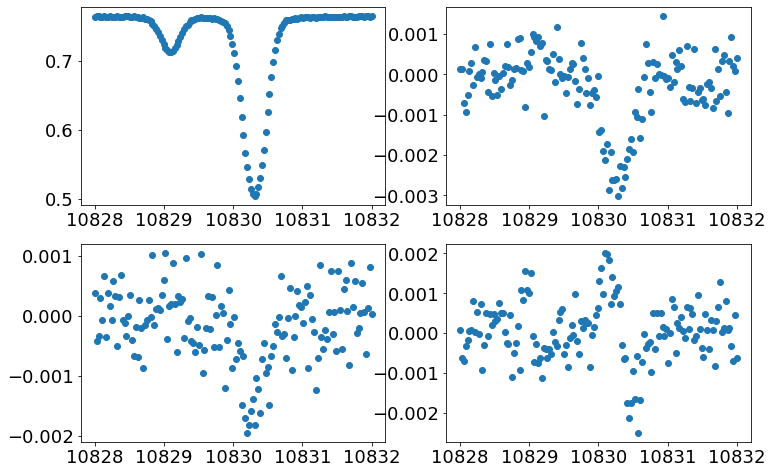

In [73]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10828, 10832, 150], 'topology': 'ch1',
    'LOS': [70.0,0.0,0.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10828, 10832]})
mod.setup()
# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff
params_original = [20.0,50.0,20.0,1.0,0.0,5.0,1.0,0.1]
mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = mod.spectrum['spec1'].wavelength_axis
n_wvl = len(ll)

# Generate random noise of a given amplitude.
noise_lvl = 5E-4
random_noise = np.random.normal(0,noise_lvl,4*150)
random_noise = random_noise.reshape(4,150)

mod.spectrum['spec1'].stokes += random_noise # condensed the addition of noise in 1 line

plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:],'o')
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:],'o')
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:],'o')
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:],'o')

In [ ]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

stokes = np.copy(mod.spectrum['spec1'].stokes)

f = open('10830_test_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'70.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [ ]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod_iter = hazel.Model('conf_test_ondisk.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=5)
iterator.use_model(model=mod_iter)
iterator.run_all_pixels()
del(mod_iter)

In [ ]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit.shape

In [ ]:
fit = fit.reshape(5,4,150)

In [ ]:
plt.figure(figsize=[12,8])
i_p = 0
plt.subplot(221)
plt.plot(ll-10830,stokes[0,:],'o')
for i in range(i_p,i_p+5):
    plt.plot(ll-10830,fit[i,0,:],label='i = '+str(i))
plt.legend()
plt.subplot(222)
plt.plot(ll-10830,stokes[1,:],'o')
for i in range(i_p,i_p+5):
    plt.plot(ll-10830,fit[i,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes[2,:],'o')
for i in range(i_p,i_p+5):
    plt.plot(ll-10830,fit[i,2,:])

plt.subplot(224)
plt.plot(ll-10830,stokes[3,:],'o')
for i in range(i_p,i_p+5):
    plt.plot(ll-10830,fit[i,3,:])


In [ ]:
result['ch1'].keys()
# Print them neatly:
for i in range(0,5):
    print ("-----------------------------")
    print ("RANDOMIZATION #: ",i)
    print ("-----------------------------")
    print ("Bx= ",result['ch1']['Bx'][0,i,0], "Original = ", params_original[0])
    print ("By= ",result['ch1']['By'][0,i,0], "Original = ", params_original[1])
    print ("Bz= ",result['ch1']['Bz'][0,i,0], "Original = ", params_original[2])
    print ("tau= ",result['ch1']['tau'][0,i,0], "Original = ", params_original[3])
    print ("vlos ",result['ch1']['v'][0,i,0], "Original = ", params_original[4])
    print ("vtherm= ",result['ch1']['deltav'][0,i,0], "Original = ", params_original[5])
    print ("a= ",result['ch1']['a'][0,i,0], "Original = ", params_original[7])

## WOW! The values are completely different (and the amount of noise does not influence that!). Let's confirm that this is indeed the case and we did not make any mistake! :-) 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
Bx0 = result['ch1']['Bx'][0,0,0]
By0 = result['ch1']['By'][0,0,0]
Bz0 = result['ch1']['Bz'][0,0,0]
print (Bx0,By0,Bz0)
Bx1 = result['ch1']['Bx'][0,3,0]
By1 = result['ch1']['By'][0,3,0]
Bz1 = result['ch1']['Bz'][0,3,0]
print (Bx1,By1,Bz1)

Bx = np.squeeze(result['ch1']['Bx'])
By = np.squeeze(result['ch1']['By'])
Bz = np.squeeze(result['ch1']['Bz'])
#vectors = np.array([[0, 0, 0, Bx0,By0,Bz0], [0, 0, 0, Bx1,By1,Bz1]],)
vectors = np.array([[0, 0, 0, Bx[0], By[0], Bz[0]], \
                    [0, 0, 0, Bx[1], By[1], Bz[1]], \
                    [0, 0, 0, Bx[2], By[2], Bz[2]],\
                    [0, 0, 0, Bx[3], By[3], Bz[3]],\
                    [0, 0, 0, Bx[4], By[4], Bz[4]]])

                                                                                        
X, Y, Z, U, V, W = zip(*vectors)
fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-50, 50])
ax.set_ylim([-50, 50])
ax.set_zlim([-50, 50])
plt.show()

# Extra content, if the time allows! 

## How sensitive is Zeeman effect at the disk center to the magnetic field? 

## Let's start from the first example:

## Very inclined magnetic field so Q, U, V are similar 

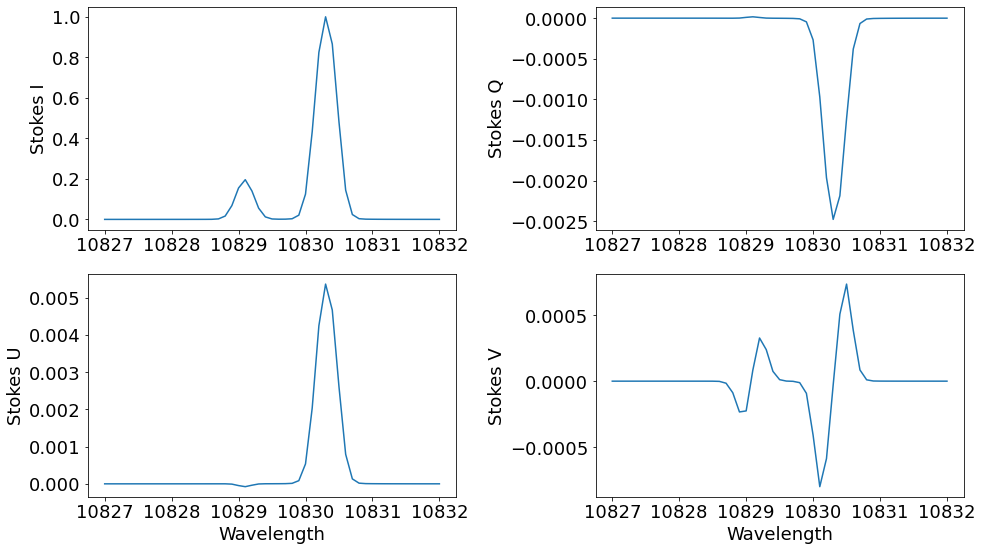

In [70]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10827, 10832, 51], 'topology': 'ch1',
    'LOS': [90.0,0.0,0.0], 'Boundary condition': [0.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 5.0, 'Line': '10830', 'Wavelength': [10827, 10832]})
mod.setup()

# Vector of parameters are (Bx,By,Bz,tau,v,deltav,beta,a) and then the ff. 
# Can you tell me which of the B components is los one, and which ones lie in the plane of the sky?
# Parameters: (Bx,By,Bz,tau,v,deltav,beta,a)

params_original = [3.0,4.0,5.0, 1.0 ,0.0, 5.0, 1.0, 0.01]

mod.atmospheres['ch1'].set_parameters(params_original,1.0)
mod.synthesize()

# This is where the wavelength hides
ll = np.copy(mod.spectrum['spec1'].wavelength_axis)
n_wvl = len(ll)

plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")
plt.tight_layout()

In [71]:
noise_lvl = 2E-3 # Huge noise!

noise = np.random.normal(0,noise_lvl,4*n_wvl).reshape(4,n_wvl)
original = np.copy(mod.spectrum['spec1'].stokes)
stokes = np.copy(mod.spectrum['spec1'].stokes) + noise

Text(0.5, 0, 'Wavelength')

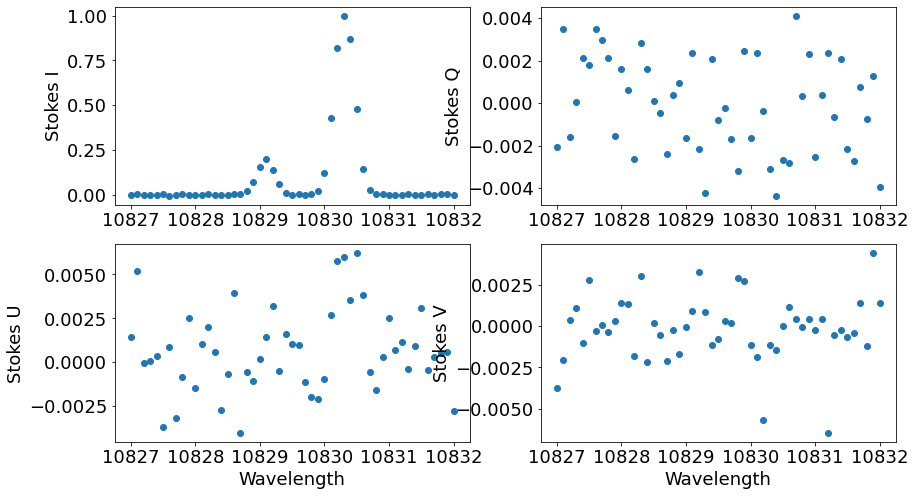

In [59]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

In [60]:
# First the wavelength axis
np.savetxt('10830_test_prom.wavelength', ll, header='lambda')
# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test_prom.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
# And finally, the 'observed' Stokes parameters:

f = open('10830_test_stokes_prom.1d', 'wb')

f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

In [61]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.

%rm output_onepixel.h5
iterator = hazel.Iterator(use_mpi=False)

mod = hazel.Model('conf_prom.ini', working_mode='inversion', verbose=2, rank=iterator.get_rank(), randomization=1)

iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-09-01 16:46:22,028 - Hazel2 v1.0
2022-09-01 16:46:22,028 - Using configuration from file : conf_prom.ini
2022-09-01 16:46:22,031 - Backtracking mode : brent
2022-09-01 16:46:22,032 - Adding spectral region spec1
2022-09-01 16:46:22,033 -   - Reading wavelength axis from 10830_test_prom.wavelength
2022-09-01 16:46:22,035 -   - Reading wavelength weights from 10830_test_prom.weights
2022-09-01 16:46:22,037 -   - Using observations from 10830_test_stokes_prom.1d
2022-09-01 16:46:22,038 -   - No mask for pixels
2022-09-01 16:46:22,038 -   - No instrumental profile
2022-09-01 16:46:22,039 -   - Using LOS ['90.00', '0.0', '0.0']
2022-09-01 16:46:22,040 -   - Using off-limb normalization (peak intensity)
2022-09-01 16:46:22,041 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2022-09-01 16:46:22,042 - Using 2 cycles
2022-09-01 16:46:22,043 - Using analytical RFs if possible : False
2022-09-01 16:46:22,045 - Using 50 max. iterations
2022-09-01 16:46:22,046 - Not using randomiza

In [62]:
result = h5py.File("output_onepixel.h5")

In [63]:
fit = np.squeeze(result['spec1']['stokes'])
fit.shape

(4, 51)

Text(0.5, 0, 'Wavelength')

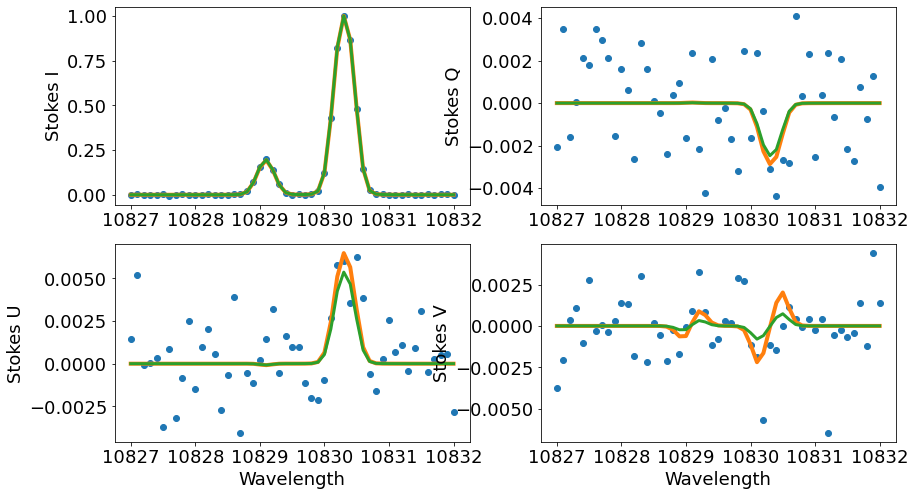

In [72]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,:], linewidth = 4)
plt.plot(ll, original[0], linewidth = 3)
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[1,:], linewidth = 4)
plt.plot(ll, original[1], linewidth = 3)
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[2,:], linewidth = 4)
plt.plot(ll, original[2], linewidth = 3)
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[3,:], linewidth = 4)
plt.plot(ll, original[3], linewidth = 3)
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

In [65]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0], "Original = ", params_original[0], "Uncertainty = ", result['ch1']['Bx_err'][0,0])
print ("By= ",result['ch1']['By'][0,0,0], "Original = ", params_original[1], "Uncertainty = ", result['ch1']['By_err'][0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0], "Original = ", params_original[2], "Uncertainty = ", result['ch1']['Bz_err'][0,0])
print ("tau= ",result['ch1']['tau'][0,0,0], "Original = ", params_original[3], "Uncertainty = ", result['ch1']['tau_err'][0,0])
print ("vlos ",result['ch1']['v'][0,0,0], "Original = ", params_original[4], "Uncertainty = ", result['ch1']['v_err'][0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0], "Original = ", params_original[5], "Uncertainty = ", result['ch1']['deltav_err'][0,0])
print ("a= ",result['ch1']['a'][0,0,0], "Original = ", params_original[7], "Uncertainty = ", result['ch1']['a_err'][0,0])
#result.close()

Bx=  8.26319014572303 Original =  3.0 Uncertainty =  [2.27631923]
By=  -8.250747141779769 Original =  4.0 Uncertainty =  [2.28098178]
Bz=  -11.27805806315807 Original =  5.0 Uncertainty =  [3.02156754]
tau=  0.9658573248986296 Original =  1.0 Uncertainty =  [0.35228345]
vlos  0.01725014158503768 Original =  0.0 Uncertainty =  [0.00493055]
vtherm=  5.019128626544656 Original =  5.0 Uncertainty =  [0.22825352]
a=  0.00781440694156862 Original =  0.01 Uncertainty =  [7.95818411]


In [26]:
%rm output_onepixel.h5